In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import collections

In [2]:
# import the ptb dataset for testing
# copy of tensorflow examples
from six.moves import range
from six.moves.urllib.request import urlretrieve
import zipfile
import string

url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

def read_data(filename):
  with zipfile.ZipFile(filename) as f:
    name = f.namelist()[0]
    data = tf.compat.as_str(f.read(name))
  return data
  
text = read_data(filename)
print('Data size %d' % len(text))

valid_size = 1000
valid_text = text[:valid_size]
train_text = text[valid_size:]
train_size = len(train_text)
print(train_size, train_text[:64])
print(valid_size, valid_text[:64])

vocabulary_size = len(string.ascii_lowercase) + 1 # [a-z] + ' '
first_letter = ord(string.ascii_lowercase[0])

def char2id(char):
  if char in string.ascii_lowercase:
    return ord(char) - first_letter + 1
  elif char == ' ':
    return 0
  else:
    print('Unexpected character: %s' % char)
    return 0
  
def id2char(dictid):
  if dictid > 0:
    return chr(dictid + first_letter - 1)
  else:
    return ' '

print(char2id('a'), char2id('z'), char2id(' '), char2id('ï'))
print(id2char(1), id2char(26), id2char(0))

batch_size=64
num_unrollings=10

class BatchGenerator(object):
  def __init__(self, text, batch_size, num_unrollings):
    self._text = text
    self._text_size = len(text)
    self._batch_size = batch_size
    self._num_unrollings = num_unrollings
    segment = self._text_size // batch_size
    self._cursor = [ offset * segment for offset in range(batch_size)]
    self._last_batch = self._next_batch()
  
  def _next_batch(self):
    """Generate a single batch from the current cursor position in the data."""
    batch = np.zeros(shape=(self._batch_size, vocabulary_size), dtype=np.float)
    for b in range(self._batch_size):
      batch[b, char2id(self._text[self._cursor[b]])] = 1.0
      self._cursor[b] = (self._cursor[b] + 1) % self._text_size
    return batch
  
  def next(self):
    """Generate the next array of batches from the data. The array consists of
    the last batch of the previous array, followed by num_unrollings new ones.
    """
    batches = [self._last_batch]
    for step in range(self._num_unrollings):
      batches.append(self._next_batch())
    self._last_batch = batches[-1]
    
    batches_ret = np.transpose(np.array(batches), (1,0,2))
    x = batches_ret[:,0:num_unrollings,:]
    y = batches_ret[:,1:,:]
    
    return x,y

def characters(probabilities):
  """Turn a 1-hot encoding or a probability distribution over the possible
  characters back into its (most likely) character representation."""
  return [id2char(c) for c in np.argmax(probabilities, 1)]

def batches2string(batches):
  """Convert a sequence of batches back into their (most likely) string
  representation."""
  s = [''] * batches[0].shape[0]
  for b in batches:
    s = [''.join(x) for x in zip(s, characters(b))]
  return s

train_batches = BatchGenerator(train_text, batch_size, num_unrollings)
valid_batches = BatchGenerator(valid_text, 1, 1)

Found and verified text8.zip
Data size 100000000
(99999000, 'ons anarchists advocate social relations based upon voluntary as')
(1000, ' anarchism originated as a term of abuse first used against earl')
Unexpected character: ï
(1, 26, 0, 0)
('a', 'z', ' ')


In [3]:
x,y = train_batches.next()

In [4]:
x.shape, y.shape

((64, 10, 27), (64, 10, 27))

In [5]:
from os import sys, path
sys.path.append(path.dirname(path.abspath('.')))

In [6]:
from layers import *


# TODO: add batch re-norm and dropout
class LSTM(object):
    '''Class defining the overall model based on layers.py'''
    def __init__(self, args):

        self.seq_len = args['seq_len']
        self.num_layers = args['num_layers']
        self.cell = args['cell']
        self.hidden_units = args['hidden_units']
        self.ip_channels = args['ip_channels']
        self.op_classes = args['op_channels']
        self.mode = args['mode']
        self.init_lr = args['lr_rate']
        self.grad_clip = args['grad_clip']
        self.batch_size = args['batch_size']

    def build_graph(self):

        self._build_model()

        if self.mode == 'train':
            self._add_train_nodes()
        self.summaries = tf.summary.merge_all()

    def _build_model(self):

        # define placeholder for data layer
        self.input_layer_x = tf.placeholder(dtype=tf.float32, shape=[self.batch_size, self.seq_len,self.ip_channels],name='input_layer_x')

        # define model based on cell and num_layers
        if self.num_layers ==1:
          self.lstm_layer = lstmLayer(self.hidden_units)
        else:
          cells = [lstmLayer(self.hidden_units)]*self.num_layers
          self.lstm_layer = DeepLSTM(cells)

        # TODO: Think about the need for statefullness in this problem scenario
        self.initial_state = tf.zeros([self.batch_size,self.lstm_layer.state_size],tf.float32)
        #self.initial_state = tf.placeholder(tf.float32,[None, self.lstm_layer.state_size])

        state = self.initial_state
        output = tf.zeros([self.batch_size,self.hidden_units],dtype=tf.float32)
        outputs = []
        # run the model for multiple time steps
        with tf.variable_scope("RNN"):
          for time in range(self.seq_len):
            if time > 0: tf.get_variable_scope().reuse_variables()
            # pass the inputs, state and weather we are in train/test or inference time (for dropout)
            output, state = self.lstm_layer(self.input_layer_x[:,time,:], state)
            outputs.append(output)
        
        self.final_output = tf.reshape(tf.concat(outputs,1),[-1,self.hidden_units])

        softmax_w = tf.get_variable('softmax_w', [self.hidden_units, self.op_classes],dtype=tf.float32,
                                    initializer=tf.random_uniform_initializer())
        softmax_b = tf.get_variable('softmax_b', [self.op_classes],dtype=tf.float32,
                                    initializer=tf.random_uniform_initializer())

        self.logits = tf.reshape(tf.matmul(self.final_output, softmax_w) + softmax_b,
                                 [self.batch_size,self.seq_len,self.op_classes])

        # get probabilities for these logits through softmax (will be needed for sampling)
        final_seq_op = tf.squeeze(tf.slice(self.logits,[0,self.seq_len-1,0],[-1,1,-1]))
        self.output_prob = tf.nn.softmax(final_seq_op)
        activation_summary(self.output_prob)

    def _add_train_nodes(self):

        # define placeholder for target layer
        self.input_layer_y = tf.placeholder(tf.float32, [self.batch_size,self.seq_len,self.op_classes],name='input_layer_y')

        # sequence loss by example
        # TODO: Implement proper loss function for encoder like structure of LSTM
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=tf.concat(self.logits,0),
                                                                           labels=tf.concat(self.input_layer_y,0)))
        tf.summary.scalar("loss",self.cost)

        self.lr = tf.Variable(self.init_lr, trainable=False)
        trainable_variables = tf.trainable_variables()
        optimizer = tf.train.AdamOptimizer(self.lr)
        grads_vars = optimizer.compute_gradients(self.cost,trainable_variables)

        # histogram_summaries for weights and gradients
        for var in tf.trainable_variables():
            tf.summary.histogram(var.op.name, var)
        for grad, var in grads_vars:
            if grad is not None:
                tf.summary.histogram(var.op.name+'/gradient',grad)

        # TODO: Think about how gradient clipping is implemented, cross check
        grads, _ = tf.clip_by_global_norm([grad for (grad,var) in grads_vars], self.grad_clip)
        self.train_op = optimizer.apply_gradients(grads_vars)

    def assign_lr(self,session,lr_value):
        session.run(tf.assign(self.lr, lr_value))

    def initialize_state(self,session):
        session.run(self.initial_state)

In [7]:
# Compare against tensorflow implementation of BiLSTM
from tensorflow.contrib.rnn import BasicLSTMCell, static_bidirectional_rnn

class tfBiLSTM(object):
    
    def __init__(self,args):
        
        self.n_hidden = args['hidden_units']
        self.n_classes = args['op_channels']
        self.batch_size = args['batch_size']
        self.seq_len = args['seq_len']
        self.ip_channels = args['ip_channels']
        self.mode = args['mode']
        self.init_lr = args['lr_rate']
        self.op_classes = args['op_channels']
        self.grad_clip = args['grad_clip']
    
    def build_graph(self):
        
        self._build_model()
        if self.mode == 'train':
            self._add_training_nodes()
        self.summaries = tf.summary.merge_all()
    
    def _build_model(self):
        
        self.input_layer_x = tf.placeholder(dtype=tf.float32, shape=[self.batch_size, self.seq_len,self.ip_channels],name='input_layer_x')
        
        x = []+ tf.split(tf.transpose(self.input_layer_x, [1,0,2]), self.seq_len, axis=0)
        x = [tf.squeeze(it) for it in x]
        
        weights = {'out': tf.Variable(tf.random_normal([2*self.n_hidden, self.n_classes]))}
        biases = {'out': tf.Variable(tf.random_normal([self.n_classes]))}

        # Forward direction cell
        lstm_fw_cell = BasicLSTMCell(self.n_hidden, forget_bias=1.0)
        # Backward direction cell
        lstm_bw_cell = BasicLSTMCell(self.n_hidden, forget_bias=1.0)
        outputs, _, _ = static_bidirectional_rnn(lstm_fw_cell, lstm_bw_cell, x, dtype=tf.float32)
        
        final_output = tf.reshape(tf.concat(outputs,1),[-1,2*self.n_hidden])
        
        self.logits = tf.reshape(tf.matmul(final_output, weights['out']) + biases['out'],
                                 [self.batch_size,self.seq_len,self.op_classes])
        
        # get probabilities for these logits through softmax (will be needed for sampling)
        final_seq_op = tf.squeeze(tf.slice(self.logits,[0,self.seq_len-1,0],[-1,1,-1]))
        self.output_prob = tf.nn.softmax(final_seq_op)
        activation_summary(self.output_prob)
        
    def _add_training_nodes(self):
        
        self.input_layer_y = tf.placeholder(tf.float32, [self.batch_size,self.seq_len,self.op_classes],name='input_layer_y')
        
        self.lr = tf.Variable(self.init_lr, trainable=False)

        # Define loss and optimizer
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=tf.concat(self.logits,0), 
                                                                        labels=tf.concat(self.input_layer_y,0)))
        
        
        trainable_variables = tf.trainable_variables()
        optimizer = tf.train.AdamOptimizer(self.lr)
        grads_vars = optimizer.compute_gradients(self.cost,trainable_variables)

        # histogram_summaries for weights and gradients
        for var in tf.trainable_variables():
            tf.summary.histogram(var.op.name, var)
        for grad, var in grads_vars:
            if grad is not None:
                tf.summary.histogram(var.op.name+'/gradient',grad)

        # TODO: Think about how gradient clipping is implemented, cross check
        grads, _ = tf.clip_by_global_norm([grad for (grad,var) in grads_vars], self.grad_clip)
        self.train_op = optimizer.apply_gradients(grads_vars)
        
    def assign_lr(self,session,lr_value):
        session.run(tf.assign(self.lr, lr_value))

In [8]:
# Bi-directional LSTM code based on LSTM code

class BiLSTM(object):
    
    def __init__(self,args):
        
        self.seq_len = args['seq_len']
        self.num_layers = args['num_layers']
        self.cell = args['cell']
        self.hidden_units = args['hidden_units']
        self.op_classes = args['op_channels']
        self.ip_channels = args['ip_channels']
        self.mode = args['mode']
        self.init_lr = args['lr_rate']
        self.grad_clip = args['grad_clip']
        self.batch_size = args['batch_size']
        
    def build_graph(self):
        
        self._build_model()
        
        if self.mode == 'train':
            self._add_training_nodes()
        self.summaries = tf.summary.merge_all()
        
        
    def _build_model(self):
        
        # define placeholder for data layer
        self.input_layer_x = tf.placeholder(dtype=tf.float32, shape=[self.batch_size,self.seq_len,self.ip_channels],name='input_layer_x')

        # define model based on cell and num_layers
        self.fw_lstm_layer = lstmLayer(self.hidden_units)
        self.bk_lstm_layer = lstmLayer(self.hidden_units)

        self.initial_state = tf.zeros([self.batch_size,self.fw_lstm_layer.state_size],tf.float32)
        #self.initial_state = tf.placeholder(tf.float32,[None, self.lstm_layer.state_size])

        def _run_loop(input_data,name):
            state = self.initial_state
            output = tf.zeros([self.batch_size,self.hidden_units],dtype=tf.float32)
            outputs = []
            # run the model for multiple time steps
            with tf.variable_scope(name+"LSTM"):
              for time in range(self.seq_len):
                if time > 0: tf.get_variable_scope().reuse_variables()
                # pass the inputs, state and weather we are in train/test or inference time (for dropout)
                output, state = self.fw_lstm_layer(input_data[:,time,:], state)
                outputs.append(output)
                
            return outputs
        
        # run the forward chain
        fw_outputs = _run_loop(self.input_layer_x,'fw_')
        # run the backward chain
        bk_input_x = tf.reverse(self.input_layer_x, [False, True])
        bk_outputs = _run_loop(bk_input_x,'bk_')[::-1]
        
        # concat the forward and backward runs
        flat_outputs = tuple(tf.concat([fw, bw], 1) for fw, bw in zip(fw_outputs, bk_outputs))
        self.final_output = tf.reshape(tf.concat(flat_outputs,1),[-1,2*self.hidden_units])
        
        # now combine with softmax to produce output
        softmax_w = tf.get_variable('softmax_w', [2*self.hidden_units, self.op_classes],dtype=tf.float32,
                                    initializer=tf.random_uniform_initializer())
        softmax_b = tf.get_variable('softmax_b', [self.op_classes],dtype=tf.float32,
                                    initializer=tf.random_uniform_initializer())

        self.logits = tf.reshape(tf.matmul(self.final_output, softmax_w) + softmax_b,
                                 [self.batch_size,self.seq_len,self.op_classes])

        # get probabilities for these logits through softmax (will be needed for sampling)
        final_seq_op = tf.squeeze(tf.slice(self.logits,[0,self.seq_len-1,0],[-1,1,-1]))
        self.output_prob = tf.nn.softmax(final_seq_op)
        activation_summary(self.output_prob)

    def _add_training_nodes(self):

        # define placeholder for target layer
        self.input_layer_y = tf.placeholder(tf.float32, [self.batch_size,self.seq_len,self.op_classes],name='input_layer_y')

        # sequence loss by example
        # TODO: Implement proper loss function for encoder like structure of LSTM
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = tf.concat(self.logits,0),
                                                                           labels = tf.concat(self.input_layer_y,0)))
        tf.summary.scalar("loss",self.cost)

        self.lr = tf.Variable(self.init_lr, trainable=False)
        trainable_variables = tf.trainable_variables()
        optimizer = tf.train.AdamOptimizer(self.lr)
        grads_vars = optimizer.compute_gradients(self.cost,trainable_variables)

        # histogram_summaries for weights and gradients
        for var in tf.trainable_variables():
            tf.summary.histogram(var.op.name, var)
        for grad, var in grads_vars:
            if grad is not None:
                tf.summary.histogram(var.op.name+'/gradient',grad)

        # TODO: Think about how gradient clipping is implemented, cross check
        grads, _ = tf.clip_by_global_norm([grad for (grad,var) in grads_vars], self.grad_clip)
        self.train_op = optimizer.apply_gradients(grads_vars)

    def assign_lr(self,session,lr_value):
        session.run(tf.assign(self.lr, lr_value))

    def initialize_state(self,session):
        session.run(self.initial_state)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
{'grad_clip': 5.0, 'num_layers': 1, 'batch_size': 64, 'num_epochs': 10, 'lr_rate': 0.05, 'hidden_units': 48, 'op_channels': 27, 'cell': 'lstm', 'ip_channels': 27, 'seq_len': 10, 'lr_decay': 0.97, 'mode': 'train'}
Runtime of one epoch: 
5.70943307877
Average cost per epoch: 
0.248844035417
Runtime of one epoch: 
5.52858877182
Average cost per epoch: 
0.195611312509
Runtime of one epoch: 
5.5717921257
Average cost per epoch: 
0.192651787773
Runtime of one epoch: 
5.60090899467
Average cost per epoch: 
0.190048263967
Runtime of one epoch: 
5.68045496941
Average cost per epoch: 
0.190043335974
Runtime of one epoch: 
5.66954898834
Average cost per epoch: 
0.185159908608
Runtime of one epoch: 
5.78203892708
Average cost per epoch: 
0.183031436875
Runtime of one epoch: 
5.88698196411
Average cost per epoch: 
0.184269254684
Runtime of one epoch: 
5.65057182312
Average cost per epoch: 
0.18285661424
Runtime of one epoch: 

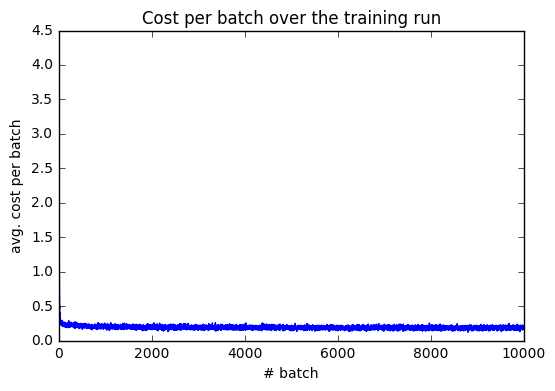

In [9]:
# Testing
import time
from matplotlib import pyplot as plt

args = {'num_epochs': 10, 'lr_rate': 0.05, 'lr_decay': 0.97, 'seq_len': 10, 'num_layers': 1, 'cell': 'lstm', 
        'hidden_units': 48, 'op_channels': 27, 'ip_channels': 27 ,'grad_clip': 5.0, 'batch_size': 64}

# Initialize session and graph
with tf.Graph().as_default(), tf.Session() as session:
    
    args['mode'] = 'train'

    with tf.variable_scope("model", reuse=None):

        model = tfBiLSTM(args)
        model.build_graph()
        tf.initialize_all_variables().run()
        
        print args

        cost_over_batches = []

        for i in range(args['num_epochs']):
            lr_decay = args['lr_decay'] ** max(i - 2.0, 0.0)
            model.assign_lr(session, args['lr_rate'] * lr_decay)

            start_time = time.time()
            softmax_op = np.zeros((1000*model.batch_size,model.op_classes))
            cost_trajectory = []
            epoch_cost = 0.0

            for i in range(1000):
                x,y = train_batches.next()
                summary, cur_cost, output_prob, _ = session.run([model.summaries,model.cost,model.output_prob,model.train_op],
                            feed_dict={model.input_layer_x: x, model.input_layer_y: y})
                cost_trajectory.append(cur_cost)
                softmax_op[i*len(y):(i+1)*len(y),:] = output_prob
                epoch_cost += cur_cost

            end_time = time.time()

            print("Runtime of one epoch: ")
            print(end_time-start_time)
            print("Average cost per epoch: ")
            print(epoch_cost/1000)

            cost_over_batches += cost_trajectory

        plt.plot(np.linspace(1,len(cost_over_batches),len(cost_over_batches)),cost_over_batches)
        plt.title('Cost per batch over the training run')
        plt.xlabel('# batch')
        plt.ylabel('avg. cost per batch')
        plt.show()